In [1]:
import numpy
#scipy.special for the sigmoid function expit()
import scipy.special
import matplotlib.pyplot as plt
%matplotlib inline
import cv2 as cv2

In [2]:
class NeuralNetwork:
################################################################################
    def __init__(self, input_nodes, hidden_nodes, output_nodes, learning_rate):
        self.iNodes = input_nodes
        self.hNodes = hidden_nodes
        self.oNodes = output_nodes
        
        self.learningRate = learning_rate
    
        #link weight matrices 
        #self.weightsInputToHidden = (numpy.random.rand(self.hNodes, self.hNodes) - 0.5)
        #self.weightsHiddenToOutput = (numpy.random.rand(self.oNodes, self.hNodes) - 0.5)
        
        #Optinal: Weight initialisation by connections to nodes 1/√number_of_inputs
        self.weightsInputToHidden = numpy.random.normal(0.0, pow(self.hNodes, -0.5), (self.hNodes, self.iNodes))
        self.weightsHiddenToOutput = numpy.random.normal(0.0, pow(self.oNodes, -0.5), (self.oNodes, self.hNodes))
        
        #sigmoid activation function
        self.activationFunction = lambda x : scipy.special.expit(x)
        #the invers sigmoid function for backward query
        self.inverse_activation_function = lambda x : scipy.special.logit(x)
        
################################################################################        
    def train(self, inputs_list, targets_list):
        # convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        targets = numpy.array(targets_list, ndmin=2).T
        
        #query the network
        final_outputs, hidden_outputs = self.query(inputs_list)
        
        # calculate error
        output_errors = targets - final_outputs
        hidden_errors = numpy.dot(self.weightsHiddenToOutput.T, output_errors)
        
        # update weights for the links between the hidden and output layers
        self.weightsHiddenToOutput += self.learningRate \
                                    * numpy.dot((output_errors * final_outputs * 
                                                (1.0 - final_outputs)), 
                                                numpy.transpose(hidden_outputs))
            
        # update weights for the links between the input and hidden layers
        self.weightsInputToHidden += self.learningRate \
                                    * numpy.dot((hidden_errors * hidden_outputs * 
                                                (1.0 - hidden_outputs)), 
                                                numpy.transpose(inputs))
        
################################################################################      
    #query the nerual network
    def query(self, inputs_list):
        #convert inputs list to 2d array
        inputs = numpy.array(inputs_list, ndmin=2).T
        
        #calculate signals to hidden layer
        hidden_inputs = numpy.dot(self.weightsInputToHidden, inputs)
        #calculate signals emerging from hidden layer
        hidden_outputs = self.activationFunction(hidden_inputs)
        
        #calculate signals to final layer
        final_inputs = numpy.dot(self.weightsHiddenToOutput, hidden_outputs)
        #calculate signals emerging from output layer
        final_outputs = self.activationFunction(final_inputs)
        
        return final_outputs, hidden_outputs
################################################################################
    # backquery the neural network
    def backquery(self, targets_list):
        # transpose the targets list to a vertical array
        final_outputs = numpy.array(targets_list, ndmin=2).T
        
        # calculate the signal into the final output layer
        final_inputs = self.inverse_activation_function(final_outputs)

        # calculate the signal out of the hidden layer
        hidden_outputs = numpy.dot(self.weightsHiddenToOutput.T, final_inputs)
        # scale them back to 0.01 to .99
        hidden_outputs -= numpy.min(hidden_outputs)
        hidden_outputs /= numpy.max(hidden_outputs)
        hidden_outputs *= 0.98
        hidden_outputs += 0.01
        
        # calculate the signal into the hidden layer
        hidden_inputs = self.inverse_activation_function(hidden_outputs)
        
        # calculate the signal out of the input layer
        inputs = numpy.dot(self.weightsInputToHidden.T, hidden_inputs)
        # scale them back to 0.01 to .99
        inputs -= numpy.min(inputs)
        inputs /= numpy.max(inputs)
        inputs *= 0.98
        inputs += 0.01
        
        return inputs

Loading training data ...
Training started ...
Epoch 0 started ...
Epoch 1 started ...
Epoch 2 started ...
Epoch 3 started ...
Epoch 4 started ...
Training finished


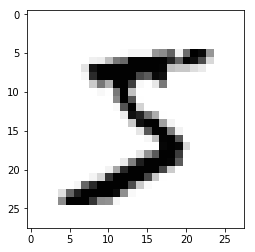

In [3]:
# number of input, hidden and output nodes
input_nodes = 784
hidden_nodes = 200
output_nodes = 10

learning_rate = 0.1

epochs = 5

# create instance of neural network
n = NeuralNetwork(input_nodes, hidden_nodes, output_nodes, learning_rate)

# load the MNIST training data
print("Loading training data ...")
training_data_file = open("MNIST/mnist_train.csv", 'r')
training_data_list = training_data_file.readlines()
training_data_file.close()

# show an example for the training data
example_values = training_data_list[0].split(',')
image_array = numpy.asfarray(example_values[1:]).reshape(28,28)
plt.imshow(image_array, cmap='Greys', interpolation='None')

print("Training started ...")

#train the nerual network 
for epoch in range(epochs):
    print("Epoch " + str(epoch) + " started ...")
    for record in training_data_list:
        # split the record by the seperator
        all_values = record.split(',')
        # scale and shift the inputs
        scaled_input = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
        # create the target output values
        targets = numpy.zeros(output_nodes) + 0.01
        targets[int(all_values[0])] = 0.99
        n.train(scaled_input, targets)

print("Training finished")

In [4]:
# load the MNIST test data
test_data_file = open("MNIST/mnist_test.csv", 'r')
test_data_list = test_data_file.readlines()
test_data_file.close()

# scorecard for how well the network performs
scorecard = []

# test the neural network
for record in test_data_list:
    # split the record by the seperator
    all_values = record.split(',')
    #correct answer
    correct_label = int(all_values[0])
    # scale and shift the inputs
    scaled_input = (numpy.asfarray(all_values[1:]) / 255.0 * 0.99) + 0.01
    # query the network 
    outputs, _ = n.query(scaled_input)
    # the index with the highest value correspond to the label
    label = numpy.argmax(outputs)
    # append correct or incorrect to list
    if (label == correct_label):
        scorecard.append(1)
    else:
        scorecard.append(0)

#calculate the performance score
scorecard_array = numpy.asarray(scorecard)
print("Performance = ", scorecard_array.sum() / scorecard_array.size)

Performance =  0.972


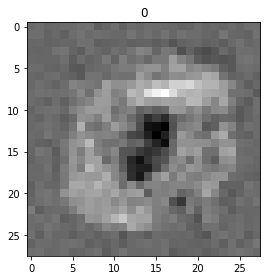

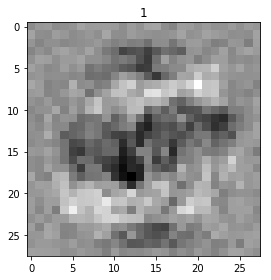

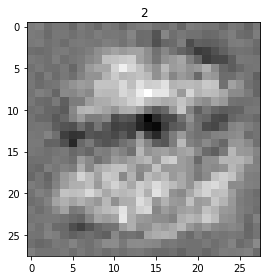

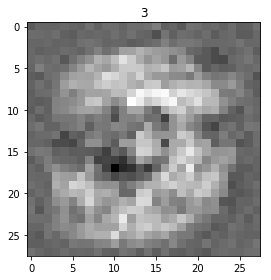

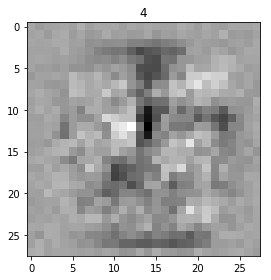

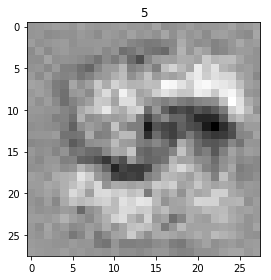

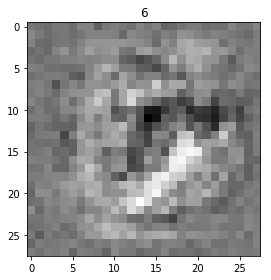

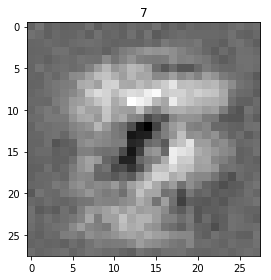

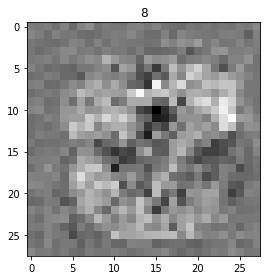

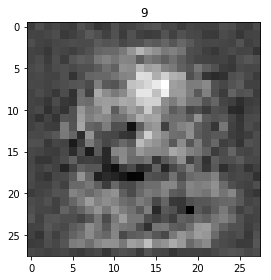

In [32]:
# run the network backwards, given a label, see what image it produces

for label in range(0,10):
    # create the output signals for this label
    targets = numpy.zeros(output_nodes) + 0.01
    targets[label] = 0.99

    # get image data
    image_data = n.backquery(targets)

    plt.title(label)
    plt.imshow(image_data.reshape(28,28), cmap='gray', interpolation='None')
    plt.tight_layout()
    plt.show()


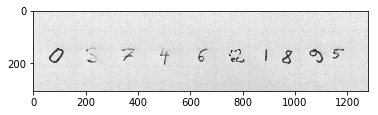

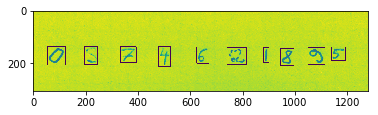

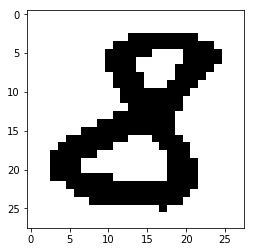

Predicted as 8


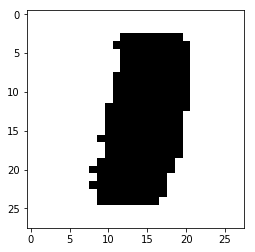

Predicted as 3


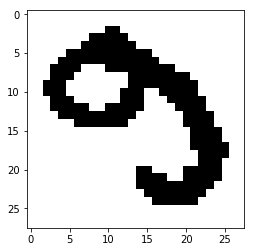

Predicted as 0


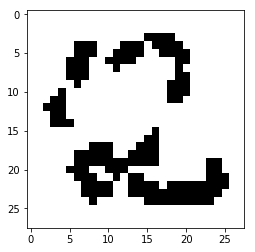

Predicted as 2


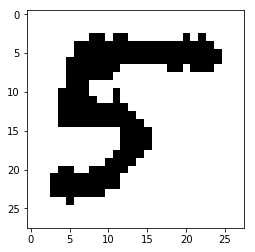

Predicted as 8


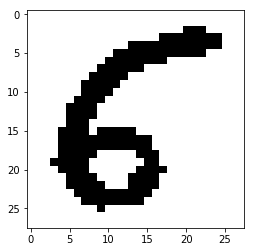

Predicted as 8


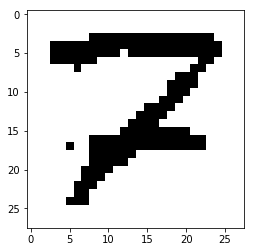

Predicted as 2


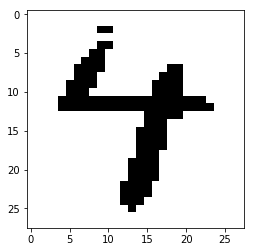

Predicted as 7


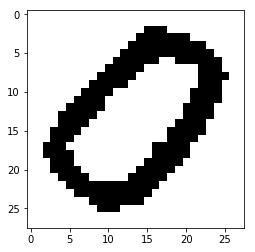

Predicted as 0


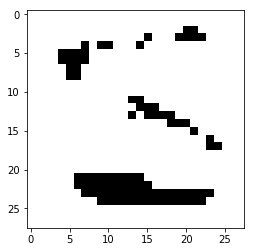

Predicted as 3


In [33]:
# Read image
img = cv2.imread("numbers.jpg",0)

# resize the image
resized_img = cv2.resize(img, (0,0), fx=0.5, fy=0.5) 
# show the result
plt.imshow(resized_img, cmap='gray')
plt.show()

# apply threshold on image
_,threshold_image = cv2.threshold(resized_img,160,255,cv2.THRESH_BINARY)
# show the result
#plt.imshow(threshold_image, cmap='gray')
#plt.show()

# dilate, close and open image
kernel = numpy.ones((5,5),numpy.uint8)
morph_image = cv2.dilate(cv2.bitwise_not(threshold_image),kernel,iterations = 3)
morph_image = cv2.morphologyEx(morph_image.copy(), cv2.MORPH_CLOSE, kernel)
morph_image = cv2.morphologyEx(morph_image.copy(), cv2.MORPH_OPEN, kernel)
# show the result
#plt.imshow(morph_image, cmap='gray')
#plt.show()

# find conturs in image
_, contours, hirachy = cv2.findContours(morph_image,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)

#contours_image = cv2.drawContours(resized_img.copy(), contours, -1, (0,255,0), 3, 1, hirachy, 1)
# show the result
#plt.imshow(contours_image, cmap='gray')
#plt.show()

# crop the image and resize to 28x28 px
number_images = []
bunding_box_image = resized_img.copy()
for c in contours:
    rect = cv2.boundingRect(c)
    x,y,w,h = rect
    
    # Crop from x, y, w, h
    # NOTE: its img[y: y + h, x: x + w]
    crop_image = resized_img.copy()[y:y+h, x:x+w]
    resized_number_image = cv2.resize(crop_image, (28,28))
    _,result_image = cv2.threshold(resized_number_image,170,255,cv2.THRESH_BINARY_INV)
    
    number_images.append(result_image)

    cv2.rectangle(bunding_box_image,(x,y),(x+w,y+h),(0,255,0),2)

# show the bounding boxes
plt.imshow(bunding_box_image)
plt.show()

for number_img in number_images:

    scaled_input = (numpy.asfarray(number_img.reshape(784)) / 255.0 * 0.99) + 0.01
    
    # query the network 
    outputs, _ = n.query(scaled_input)
    #print(outputs)
    # the index with the highest value correspond to the label
    label = numpy.argmax(outputs)
    
    # print the image 
    plt.imshow(number_img, cmap='binary')
    plt.show()
    
    # show the result
    print("Predicted as " + str(label))
    
    
    
